In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,ConcatDataset

%matplotlib inline

In [ ]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32,padding=4,padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [ ]:
train_data = CIFAR100(download=True,root="./data",transform=train_transform)
test_data = CIFAR100(root="./data",train=False,transform=test_transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
# for image,label in train_data:
    # print("Image shape: ",image.shape)
    # print("Image tensor: ", image)
    # print("Label: ", label)


In [ ]:
train_data.classes
print(train_data.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

Word2vec

In [ ]:
import gensim
import gensim.downloader
words=[]
for word in train_data.classes:
  if '_' in word:
    words.append(word.split('_')[0])
  else:
    words.append(word)
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
label_embdding = []
for w in words:
  if w in glove_vectors.vocab:
    label_embdding.append(glove_vectors[w])
  else:
    label_embdding.append(glove_vectors['unknown'])

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
BATCH_SIZE=128
train_dl = DataLoader(train_data,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_data,BATCH_SIZE,num_workers=4,pin_memory=True)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


In [ ]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl,device)
test_dl = ToDeviceLoader(test_dl,device)

cuda


In [ ]:
def accuracy(predicted,actual):
    _, predictions = torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

class BaseModel(nn.Module):
    def training_step(self,batch):
        images,labels = batch
        similarity_batch=[]
        target=[]
        for i in range(labels.shape[0]):
          similarity_batch.append(label_embdding[labels[i]])
          target.append(1)
        similarity_batches=torch.tensor(np.array(similarity_batch)).cuda()
        target=torch.tensor(np.array(target)).cuda()
        out1,out2 = self(images)
        criterition=torch.nn.CosineEmbeddingLoss()
        loss = F.cross_entropy(out1,labels)+criterition(out2,similarity_batches,target)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out1,out2 = self(images)
        loss = F.cross_entropy(out1,labels)
        acc = accuracy(out1,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
        

In [ ]:
def conv_shortcut(in_channel,out_channel,stride):
    layers = [nn.Conv2d(in_channel,out_channel,kernel_size=(1,1),stride=(stride,stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel,out_channel,k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0],kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    
    second_layers = [nn.Conv2d(out_channel[0],out_channel[1],kernel_size=(k_size,k_size),stride=(1,1),padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class Resnet50(BaseModel):
    
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=(3),stride=(1),padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3,stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024,num_classes))
        self.semanticdense = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024,300))
        
    def forward(self,inputs):
        out = self.stg1(inputs)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
#         stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out) #[128, 1024, 4, 4]
        out1 = self.classifier(out)#100x1024 #[128, 100]
        out2=self.semanticdense(out)
        return out1,out2
        
        
        

In [ ]:
model = Resnet50(3,100)


In [ ]:
model = to_device(model,device)

In [ ]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs,train_dl,test_dl,model,optimizer,max_lr,weight_decay,scheduler,grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(),max_lr,weight_decay=weight_decay)
    
    scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model,test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

In [ ]:
history = [evaluate(model,test_dl)]

In [ ]:
epochs = 25
optimizer = torch.optim.Adam
max_lr=0.01
grad_clip = 0.1
weight_decay = 1e-4
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [ ]:
%%time
history += fit(epochs=epochs,train_dl=train_dl,test_dl=test_dl,model=model,optimizer=optimizer,max_lr=max_lr,grad_clip=grad_clip,
              weight_decay=weight_decay,scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00082, train_loss: 4.2006, val_loss: 3.2028, val_acc: 0.2106
Epoch [1], last_lr: 0.00199, train_loss: 3.5913, val_loss: 3.0273, val_acc: 0.2575
Epoch [2], last_lr: 0.00372, train_loss: 3.1807, val_loss: 2.7909, val_acc: 0.2971
Epoch [3], last_lr: 0.00570, train_loss: 2.8454, val_loss: 2.5602, val_acc: 0.3457
Epoch [4], last_lr: 0.00760, train_loss: 2.6978, val_loss: 2.3078, val_acc: 0.3936
Epoch [5], last_lr: 0.00909, train_loss: 2.6187, val_loss: 2.6566, val_acc: 0.3363
Epoch [6], last_lr: 0.00990, train_loss: 2.5632, val_loss: 2.3154, val_acc: 0.3946
Epoch [7], last_lr: 0.00998, train_loss: 2.5210, val_loss: 2.2475, val_acc: 0.4089
Epoch [8], last_lr: 0.00982, train_loss: 2.4711, val_loss: 2.4857, val_acc: 0.3855
Epoch [9], last_lr: 0.00950, train_loss: 2.4274, val_loss: 2.1912, val_acc: 0.4264
Epoch [10], last_lr: 0.00904, train_loss: 2.3696, val_loss: 2.1985, val_acc: 0.4221
Epoch [11], last_lr: 0.00845, train_loss: 2.2994, val_loss: 2.0965, val_acc: 0.4506
Ep

In [ ]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

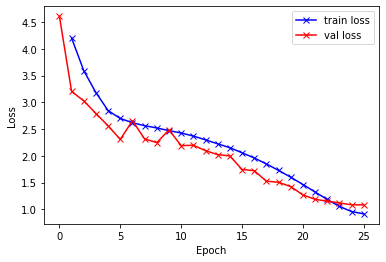

In [ ]:
plot_loss(history)

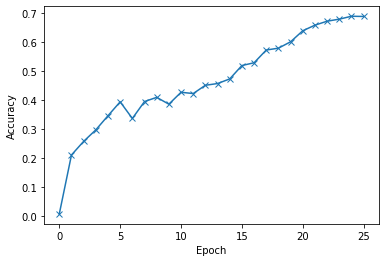

In [ ]:
plot_acc(history)

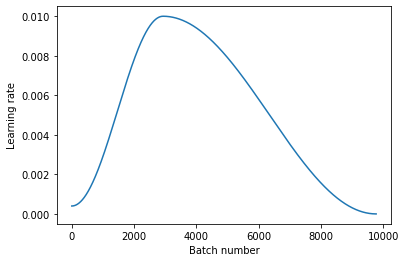

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), 'cifar100-resnet.pth')